In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
print('Setup done')

Setup done


In [2]:
# from google.colab import drive

# drive.mount('/content/gdrive',force_remount=True)

In [3]:
df = pd.read_csv('./sar.csv', sep=',')
df_client_rfm = pd.read_csv('./client_rfm.csv', sep=',')
print("dataset Loaded")

dataset Loaded


In [4]:
df_client_rfm = df_client_rfm[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']]

In [5]:
df['ProductId'].nunique()

54708

In [6]:
df_client_product = df[['Client','ProductId','Rating']].copy()
df_client_product = pd.merge(df_client_product,df_client_rfm,on='Client',how='left')

df_client_product.drop_duplicates(keep='first',inplace=True,subset=['Client','ProductId']) 


n_users = df_client_product['Client'].nunique()
n_users

10816

In [7]:
df_product = df[['ProductId','Product','Product Category','Product Cost']].copy()
df_product.drop_duplicates(keep='first',inplace=True) 

n_prod = df_product['ProductId'].nunique()
n_prod

54708

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

prod_enc = LabelEncoder()
df_client_product['Client'] = prod_enc.fit_transform(df_client_product['Client'].values)

prod_enc = LabelEncoder()
df_product['Product'] = prod_enc.fit_transform(df_product['Product'].values)

prod_cat_enc = LabelEncoder()
df_product['Product Category'] = prod_cat_enc.fit_transform(df_product['Product Category'].values)

prod_id_enc = LabelEncoder()
df_product['ProductId'] = prod_id_enc.fit_transform(df_product['ProductId'].values)
df_client_product['ProductId'] = prod_id_enc.transform(df_client_product['ProductId'].values)

In [9]:
train, test = train_test_split(df_client_product, test_size=0.2, random_state=42)

In [10]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense,Concatenate
from keras.models import Model

product_input = Input(shape=[1], name="Product-Input")

product_embedding = Embedding(n_prod+1, 5, name="Product-Embedding")(product_input)
product_vec = Flatten(name="Flatten-Product")(product_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
prod = Dot(name="Dot-Product", axes=1)([product_vec, user_vec])
model = Model([user_input, product_input], prod)
model.compile('adam', 'mean_squared_error')

In [11]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense,Concatenate
from keras.models import Model

product_input = Input(shape=[1], name="Product-Input")

product_embedding = Embedding(n_prod+1, 5, name="Product-Embedding")(product_input)
product_vec = Flatten(name="Flatten-Product")(product_embedding)

user_input = Input(shape=[5], name="User-Input")
user_embedding = Embedding(n_users+1, 8, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
# prod = Dot(name="Dot-Product", axes=1)([product_vec, user_vec])
concatted = Concatenate()([product_vec, user_vec])
d = Dense(4, kernel_initializer='normal')(concatted)
out = Dense(1, kernel_initializer='normal')(d)
model_rfm = Model([user_input, product_input], out)
model_rfm.compile('adam', 'mean_squared_error')

In [12]:
df_client_product

,Client,ProductId,Rating,Rank_Recency,Rank_Frequency,Rank_Monetary,Cluster
0,763,18402,7.5,1736,2000,2000,4
32,8310,17466,7.5,1170,2000,2000,4
64,697,14033,6.5,2001,2000,2000,4
96,763,23790,7.5,1736,2000,2000,4
128,763,16787,7.5,1736,2000,2000,4
...,...,...,...,...,...,...,...
1628892,2233,9840,4.5,1346,1562,1471,4
1628917,5848,9904,6.0,1515,1762,1802,4
1628918,6270,3711,6.0,1824,1940,1905,4
1628920,519,40335,5.0,1535,1426,1139,4


In [13]:
history = model.fit([train[['Client']],
                     train[['ProductId']]], train['Rating'],
                    validation_data=
                    ([test[['Client']],
                      test['ProductId']], test['Rating']), epochs=1, verbose=1)
model.save('regression_model_basic.h5')

12577/12577 [==============================] - 50s 4ms/step - loss: 22.8425 - val_loss: 18.4678


In [14]:
history_rfm = model_rfm.fit([train[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']],
                             train[['ProductId']]], train['Rating'],
                            validation_data=([test[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']],
                                              test['ProductId']], test['Rating']), epochs=5, verbose=1)
model_rfm.save('regression_model.h5')

Epoch 1/5
12577/12577 [==============================] - 50s 4ms/step - loss: 2.3014 - val_loss: 0.5036
Epoch 2/5
12577/12577 [==============================] - 50s 4ms/step - loss: 0.4197 - val_loss: 0.4595
Epoch 3/5
12577/12577 [==============================] - 51s 4ms/step - loss: 0.3742 - val_loss: 0.4451
Epoch 4/5
12577/12577 [==============================] - 54s 4ms/step - loss: 0.3492 - val_loss: 0.4414
Epoch 5/5
12577/12577 [==============================] - 52s 4ms/step - loss: 0.3326 - val_loss: 0.4362


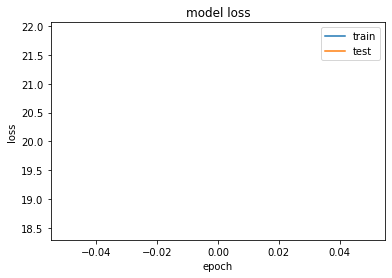

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")

plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()


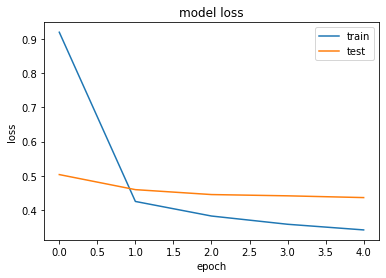

In [16]:
plt.plot(history_rfm.history["loss"])
plt.plot(history_rfm.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [17]:
test[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']].iloc[1]
test['ProductId'].values
product_db = np.array(list(set(test['ProductId'])))

In [18]:
# Creating dataset for making recommendations for the first user
# Without RFM

product_db = np.array(list(set(train['ProductId'])))

user = test[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']].iloc[1]
user = np.array([1 for i in range(len(product_db))])

predictions = model.predict([user, product_db])

predictions = np.array([a[0] for a in predictions])

# recommended_book_ids = (-predictions).argsort()[:5]
# print(recommended_book_ids)
# print(predictions[recommended_book_ids])

In [19]:
len(product_db)

51233

In [20]:
product_db = np.array(list(set(df_client_product['ProductId'])))

In [21]:
# Creating dataset for making recommendations for the first user
# With RFM

product_db = np.array(list(set(df_client_product['ProductId'])))

user = test[['Client','Rank_Recency','Rank_Frequency','Rank_Monetary','Cluster']].iloc[1].values
user_t = np.array([user for i in range(len(product_db))])

predictions = model_rfm.predict([user_t, product_db])

predictions = np.array([a[0] for a in predictions])

# recommended_book_ids = (-predictions).argsort()[:5]
# print(recommended_book_ids)
# print(predictions[recommended_book_ids])

In [22]:
predictions

array([5.334894 , 3.1164885, 3.7912755, ..., 5.2132816, 4.442734 ,
       4.636629 ], dtype=float32)

In [23]:
max(predictions)

6.6092215